In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Create inspector
inspector = inspect(engine)

# Using inspector print column names
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
recent = dt.datetime.strptime(recent, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
year_ago = recent - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
measurement_query = session.query(*[Measurement.date, Measurement.prcp]).\
    filter(Measurement.date > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(measurement_query, columns=['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(['date'], ascending=True)

# Clean up
precipitation_df = precipitation_df.dropna()
precipitation_df = precipitation_df.reset_index()
precipitation_df = precipitation_df.drop(columns=['index'])


precipitation_df.head(25)


,date,precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,2.15
4,2016-08-24,1.45
5,2016-08-24,1.22
6,2016-08-25,0.08
7,2016-08-25,0.00
8,2016-08-25,0.06
9,2016-08-25,0.00


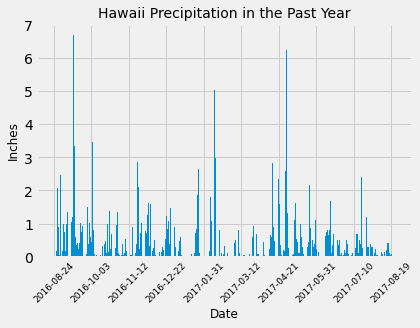

In [43]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure()

axis_date = precipitation_df['date']
axis_precip = precipitation_df['precipitation']

x_ticks = np.arange(0, 400, 40)
plt.xticks(x_ticks, rotation=45, fontsize=9)

plt.bar(axis_date, axis_precip, align='center')
plt.title('Hawaii Precipitation in the Past Year', fontsize=14)
plt.ylabel('Inches', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.savefig('./Images/precipitation.png', format='png')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [45]:
# Create inspector
inspector = inspect(engine)

# Using inspector print column names
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [48]:
# Design a query to calculate the total number stations in the dataset
session.query(Station).count()

9

In [50]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
freq_count = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()

freq_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281')

most_active = most_active[0]
most_active

('USC00519281', 54.0, 85.0, 71.66378066378067)

In [63]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_query = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > year_ago).all()

temp_df = pd.DataFrame(temp_query, columns=['station', 'tobs'])
temp_df = temp_df.dropna()
temp_df

,station,tobs
0,USC00519281,77.0
1,USC00519281,80.0
2,USC00519281,80.0
3,USC00519281,75.0
4,USC00519281,73.0
...,...,...
346,USC00519281,77.0
347,USC00519281,77.0
348,USC00519281,76.0
349,USC00519281,76.0


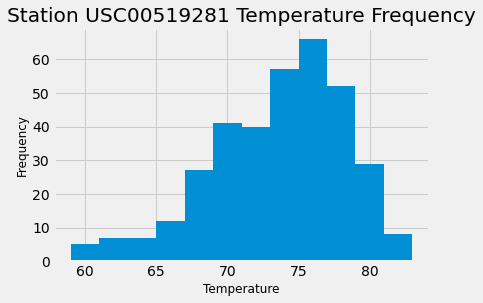

In [69]:
plt.figure()
temps = temp_df['tobs']

plt.hist(temps, bins=12, histtype='bar')
plt.title('Station USC00519281 Temperature Frequency')
plt.xlabel('Temperature', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

# Close session

In [72]:
# Close Session
session.close()